## Compute Max Speed for the Track Frame Database for Greenland
---

Use a velocity map to find the max speed for each frame.

In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import numpy as np
import grimpfunc as grimp
import nisardev as nisar
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import warnings

## Read Track Frame Data Base

In [2]:
allFrames = gpd.read_file('NISAR_TrackFrame_L_20240530.gpkg').to_crs("epsg:3413")

In [3]:
speedRange = {'slow': [0, 750], 'medium': [750.00001, 2000], 'fast1': [2000.0001, 4000], 'fast2': [4000.0001, 6000], 'superfast': [6000.00001, 18000]}
colors = {'slow': 'k', 'medium': 'blue', 'fast1': 'orange', 'fast2': 'red', 'superfast': 'magenta'}

## Read Velocity

This data set can be downloaded from https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0725.004/2020.12.01/. Download and modify the path to point to the full set of tifs.

In [4]:
myPath = '/Volumes/insar9/ian/Sentinel1/Release/annualMosaics/Vel-2020-12-01.2021-11-30/release'
urlAll = f'{myPath}/GL_vel_mosaic_Annual_01Dec20_30Nov21_*_v05.0'
allMap =  nisar.nisarVel() # Create Series
allMap.readDataFromTiff(urlAll, url=False, readSpeed=False, overviewLevel=0) 
limits = Polygon(list(zip(*allMap.outline())))


Find the frames that overlap the Greenland map and have land.

In [5]:
greenlandFrames = allFrames[allFrames.intersects(limits) & allFrames['hasLand']]

## Create Mask for Individual Frames

This function will create a mask that includes all points in the frame.

In [6]:
def makeMaskFromPolygon(polygon, data):
    # Get bounds
    ny, nx = data.shape
    x0, dx, _, y0, _, dy = [float(x) for x in data.spatial_ref.GeoTransform.split()]
    # Create empty mask
    mask = Image.new('L', (nx, ny), 0)
    # Compute frame boundary in pixel coords
    polyCoords = [( (x[1] - y0)/dy, (x[0] - x0)/dx) for x in polygon.exterior.coords]
    # Draw the mask pixels.
    ImageDraw.Draw(mask).polygon(polyCoords, outline=0, fill=1)
    # Flip and return
    return np.flipud(np.array(mask))

def getSpeedRange(speed):
    for key in speedRange:
        # print(speed)
        if speed >= speedRange[key][0] and speed <= speedRange[key][1]:
            return key
    print(speed)

## Find Maximum Speed

Loop through Frames and compute max speed.

100 - 200 - 300 - 400 - 500 - 548
CPU times: user 47.5 s, sys: 5.26 s, total: 52.8 s
Wall time: 45.9 s


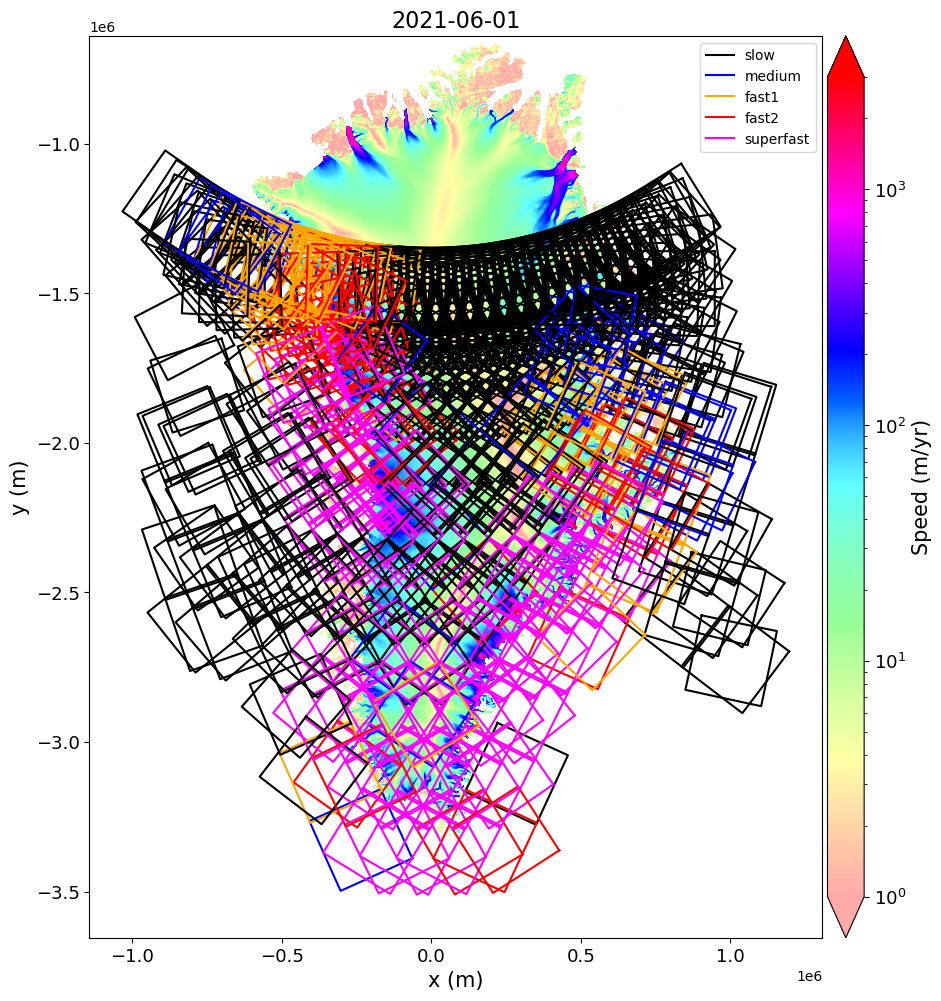

In [7]:
%%time
doPlot = True
nStop = 1000
nProcessed = 0
frames = {}
if doPlot:
    fig, ax = plt.subplots(1, 1, figsize=(10, 15))
    allMap.displayVel(ax=ax, scale='log', vmin=1, vmax=3000)
for key in speedRange:
    ax.plot(0,-1.5e6, color=colors[key], label=key)
ax.legend()

with warnings.catch_warnings():  # Catch all NaN warning
    count = 0
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for frame in greenlandFrames.iterrows():
        # subset velocity based on bounding box, then crop base on frame
        bbox = dict(zip(['minx', 'miny', 'maxx', 'maxy'], frame[1]['geometry'].bounds))
        allMap.subSetVel(bbox)
        bbox = allMap.boundingBox()
        speed = np.squeeze(allMap.subset.sel(band='vv'))
        mask = makeMaskFromPolygon(frame[1]['geometry'].geoms[0], speed )
        #
        # Compute find max speed for the frame
        maxSpeed = np.nanmax(speed * mask)
        if np.isnan(maxSpeed):
            maxSpeed = 0
        # Save result
        frames[f'{frame[1]["track"]}-{frame[1]["frame"]}'] = maxSpeed
        #
        nProcessed += 1
        #
        # Plot fastest frames
        if doPlot:

            myColor = colors[getSpeedRange(maxSpeed)]         
            tmp = np.array(list(frame[1]['geometry'].geoms[0].exterior.coords))
            #allMap.displayVel(ax=ax, scale='log', vmin=1, vmax=3000) #, masked=~mask.astype(bool))
            ax.plot(tmp[:, 0], tmp[:, 1], color=myColor);
            count += 1
        # Progress
        if nProcessed % 100 == 0:
            print(f'{nProcessed} - ', end='')
        # Stop prematurely for debugging
        if nProcessed >= nStop:
            break
    print(count)
 
#frames

Create a list of speeds.

In [8]:
speeds = np.array(list(frames.values()))

## Evaluate Search Radii

Tentative set of parameters for offsets. 

In [9]:
rangeResolution  = {'20': 11.8, '40': 5.9, '80': 3.1}
azimuthResolution  = {'20': 6, '40': 6, '80': 6}
pad = 1.  # Margin - must track speeds 1.5*max for bin. 
#speedRange = {'slow': [0, 750]nominal': [0, 6000], 'superfast': [6001, 16000]}

Find the number of frames for each bin.

In [10]:
print('\t\t\t\t\tRgRadius:AzRadius (nFrames:%Frames)\n')
print('\t', end='')
for speed in speedRange:
    print(f'{speedRange[speed][0]:4}-{speedRange[speed][1]:4} (+50%)', end='\t\t')
print('')
for bw in rangeResolution:
    print(f'{bw} MHz', end='\t')
    for speed in speedRange:
        searchRadiusRange = (pad*speedRange[speed][1]/365*12.)/rangeResolution[bw]
        searchRadiusAzimuth = (pad*speedRange[speed][1]/365*12.)/azimuthResolution[bw]
        nInRange = np.sum(np.logical_and(speeds >= speedRange[speed][0], speeds < speedRange[speed][1]))
        percentInRange =  nInRange/len(speeds) * 100
        print(f'{searchRadiusRange:3.0f}:{searchRadiusAzimuth:.0f}(\033[1;94m{nInRange}\033[0m:{percentInRange:.1f}%) ', end='\t\t')
    print('')

					RgRadius:AzRadius (nFrames:%Frames)

	   0- 750 (+50%)		750.00001-2000 (+50%)		2000.0001-4000 (+50%)		4000.0001-6000 (+50%)		6000.00001-18000 (+50%)		
20 MHz	  2:4(324:59.1%) 		  6:11(33:6.0%) 		 11:22(51:9.3%) 		 17:33(52:9.5%) 		 50:99(88:16.1%) 		
40 MHz	  4:4(324:59.1%) 		 11:11(33:6.0%) 		 22:22(51:9.3%) 		 33:33(52:9.5%) 		100:99(88:16.1%) 		
80 MHz	  8:4(324:59.1%) 		 21:11(33:6.0%) 		 42:22(51:9.3%) 		 64:33(52:9.5%) 		191:99(88:16.1%) 		


(array([324.,  33.,  51.,  52.,  88.]),
 array([    0.     ,   750.00001,  2000.0001 ,  4000.0001 ,  6000.00001,
        18000.     ]),
 <BarContainer object of 5 artists>)

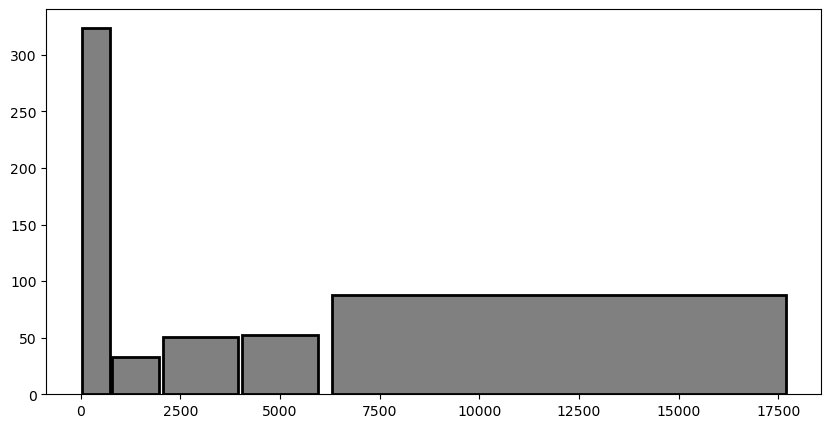

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bins = [x[0] for x in speedRange.values()]+[speedRange['superfast'][1]]
ax.hist(speeds,bins=bins, facecolor='gray', edgecolor='k', rwidth=.95, linewidth=2 )

## Save Fast Frames

In [12]:
fastFrames = greenlandFrames[speeds > 6000].to_crs("epsg:4326")

In [13]:
#fastFrames

In [14]:
fastFrames.to_file('GreenlandFastFrames.gpkg', driver='GPKG')